In [8]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 7]

In [ ]:
!aws s3 sync s3://un-big-data un_big_data

In [2]:
targets = pd.read_csv("targets.csv", parse_dates=["date"])
data = pd.read_csv("data.csv", parse_dates=["date"])
data = data.merge(targets, on="date", how="left")

# Testing with pre-existing nowcast data

In [264]:
def gen_data(data, date_to):
    tmp = data.loc[~pd.isna(data.me), :].reset_index(drop=True).dropna(axis=1)
    tmp["month"] = tmp.date.dt.month
    tmp["year"] = tmp.date.dt.year
    
    date_train = np.array(tmp.loc[tmp.date < date_to, "date"])
    date_test = np.array(tmp.loc[tmp.date >= date_to, "date"])
    
    X_train = tmp.loc[tmp.date < date_to, :].drop(["date", "me"], axis=1)
    colnames = tmp.loc[tmp.date < date_to, :].drop(["date", "me"], axis=1).columns
    scaler = sklearn.preprocessing.MinMaxScaler().fit(X)
    X_train = scaler.transform(X_train)
    
    y_train = np.array(tmp.loc[tmp.date < date_to, :].me)
    
    X_test = tmp.loc[tmp.date >= date_to, :].drop(["date", "me"], axis=1)
    X_test = scaler.transform(X_test)
    
    y_test = np.array(tmp.loc[tmp.date >= date_to, :].me)
    return X_train, X_test, y_train, y_test, date_train, date_test, colnames

In [217]:
from datetime import date
from dateutil.relativedelta import relativedelta

In [ ]:
dates = []
vals = []
for i in range(155):
    print(i)
    date_to = date(2007,1,1) + relativedelta(months=i)
    string_date_to = date_to.strftime("%Y-%m-%d")
    which_model = sklearn.tree.DecisionTreeRegressor(max_depth=100, min_samples_split=5, min_samples_leaf=2)
    #which_model = sklearn.ensemble.GradientBoostingRegressor(max_depth=4,n_estimators=200,random_state=2)
    #dt = sklearn.tree.DecisionTreeRegressor(max_depth=100, min_samples_split=5, min_samples_leaf=2)
    #which_model = sklearn.ensemble.AdaBoostRegressor(base_estimator=dt, n_estimators=180, random_state=1)

    # data
    X_train, X_test, y_train, y_test, date_train, date_test, colnames = gen_data(data, string_date_to)

    # model
    which_model = which_model.fit(X_train, y_train)
    y_pred = which_model.predict(X_test)

    dates.append((date(2007,1,1) + relativedelta(months=i+2)).strftime("%Y-%m-%d"))
    vals.append(y_pred[2])
    # plotting
    # plt.plot(date_train, y_train)
    # plt.plot(date_test, y_test, label="Actual")
    # plt.plot(date_test, y_pred, label="Predicted")
    # plt.legend()
    # plt.title(round(sklearn.metrics.mean_absolute_error(y_test, y_pred)));

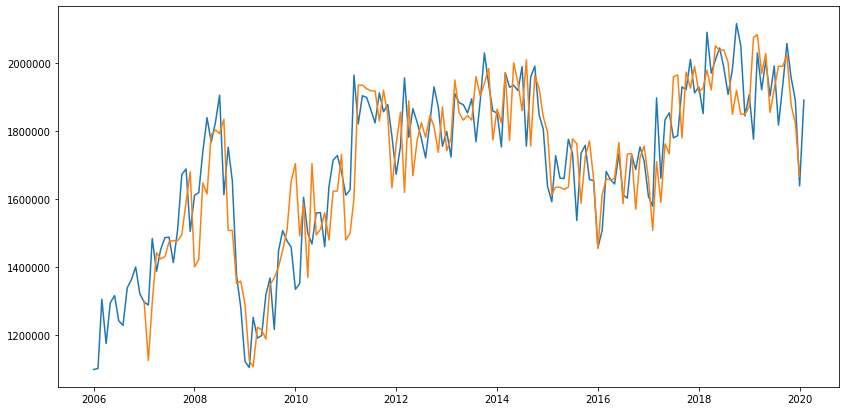

In [248]:
# dt one ahead
X_train, X_test, y_train, y_test, date_train, date_test, colnames = gen_data(data, "2020-03-01")
plt.plot(date_train, y_train)
plt.plot(pd.to_datetime(dates), vals);

In [ ]:
import statsmodels.api as sm
X_train, X_test, y_train, y_test, date_train, date_test, colnames = gen_data(data, "2020-03-01")
X_train = pd.DataFrame(X_train)
X_train.columns = colnames
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

# Testing with AIS data

In [92]:
import os
import glob
from sklearn.preprocessing import MinMaxScaler

which_folder = "un_big_data/uniqueShips"
os.chdir(which_folder)
result = glob.glob( '*/**.csv' )
result = [which_folder + "/" + x for x in result]
os.chdir("../..")

for i in range(len(result)):
    if i == 0:
        data = pd.read_csv(result[i], parse_dates=["date"])
    else:
        data = data.append(pd.read_csv(result[i], parse_dates=["date"]))
data.reset_index(drop=True, inplace=True)
data.date = data.date + pd.offsets.MonthBegin(-1)
data = data.groupby(["date", "portname"]).mean().reset_index().sort_values(["portname", "date"])
data = data.pivot(index="date", columns="portname", values="n_ships").reset_index()
start_date = data.date.min()
end_date = data.date.max()

In [132]:
X = data.drop("date", axis=1)
colnames = X.columns
X = MinMaxScaler().fit(X).transform(X)
X = pd.DataFrame(X)
X.columns = colnames
y = targets.loc[lambda x: (x.date >= start_date) & (x.date <= end_date), "se"].reset_index(drop=True)

In [133]:
import statsmodels.api as sm
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                     se   R-squared (uncentered):                   0.986
Model:                            OLS   Adj. R-squared (uncentered):              0.976
Method:                 Least Squares   F-statistic:                              96.62
Date:                Fri, 05 Jun 2020   Prob (F-statistic):                    4.29e-09
Time:                        11:07:16   Log-Likelihood:                         -217.79
No. Observations:                  19   AIC:                                      451.6
Df Residuals:                      11   BIC:                                      459.1
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/danhopp/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


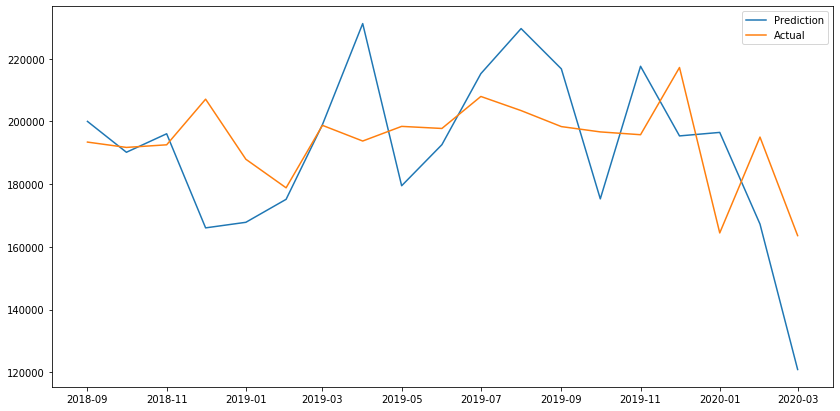

In [134]:
plt.plot(data.date, results.predict(X), label="Prediction")
plt.plot(data.date, y, label="Actual")
plt.legend();

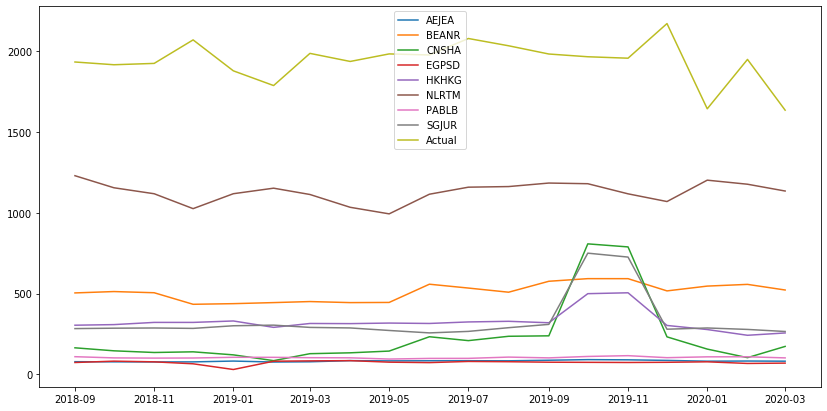

In [136]:
for col in data.columns[1:]:
    plt.plot(data.date, data[col], label=col)
plt.plot(data.date, y/100, label="Actual")
plt.legend();